In [1]:
import pandas as pd
import csv
import numpy as np
import scipy
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import random



from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.model_selection import GridSearchCV
from sklearn import datasets
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import requests
import itertools
import networkx as nx
import datetime
import io
import random
import warnings
import json
import requests
import time
import csv
import re
sns.set_palette("husl")


In [2]:
gene_loov_df = pd.read_csv('./data_generated/gene_loov_prob.csv')
gene_loov_df = gene_loov_df.sort_values('Probability',ascending = False)
gene_loov_df[gene_loov_df['Tissue'] == 'Brain'].head()

,Gene,Tissue,Label,Probability,Description,pct_rank
109450,ENSG00000154277,Brain,P,0.988585,UCHL1,1.000000
280323,ENSG00000127720,Brain,U,0.988544,METTL25,0.999935
443438,ENSG00000147140,Brain,U,0.987343,NONO,0.999871
219049,ENSG00000181090,Brain,P,0.987120,EHMT1,0.999806
440922,ENSG00000102003,Brain,P,0.986731,SYP,0.999742


# Checking Enrichment

In [2]:
def enrichment(gc):
    

    ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/addList'
    ENRICHR_ENRICH_URL = 'http://amp.pharm.mssm.edu/Enrichr/enrich'

    query_string = '?userListId=%s&backgroundType=%s'
    gene_set_library = 'GO_Biological_Process_2018'


    genes_str = '\n'.join(list(gc))
    description = 'Example gene list'
    payload = {
        'list': (None, genes_str),
        'description': (None, description)
    }

    response = requests.post(ENRICHR_URL, files=payload)
    if not response.ok:
        raise Exception('Error analyzing gene list')
    data = json.loads(response.text)
    user_list_id = data['userListId']
    ## select the library from here - http://amp.pharm.mssm.edu/Enrichr/#stats
    gene_set_library = 'GO_Biological_Process_2018'
    response = requests.get(
        ENRICHR_ENRICH_URL + query_string % (user_list_id, gene_set_library)
     )
    if not response.ok:
        print(response)
        print('Error fetching enrichment results')
    data = json.loads(response.text)
    print(json.dumps(data, indent=2))
    # time.sleep(5)


# Mice validation

In [3]:
def mice_test(mice_tis_genes,prob_df,gtex_tissue,iteration_count):
    prob_df = prob_df[prob_df['Tissue'] == gtex_tissue]
    prob_df['Prob_ranking'] = prob_df['Probability'].rank(pct = True)
    gtex_genes = set(prob_df['Description'].tolist())
    mice_tis_genes = list(set(mice_tis_genes) & gtex_genes)
    print(len(gtex_genes))
    print(len(mice_tis_genes))
    random_count = int(len(mice_tis_genes)*0.9)    
    mice_ranks = []
    rand_ranks = []
    for i in range(iteration_count):
        mice_list = random.sample(mice_tis_genes,random_count)
        rand_list = random.sample(gtex_genes,random_count)
        mice_rank = np.mean(prob_df[prob_df['Description'].isin(mice_list)]['Prob_ranking'].tolist())
        rand_rank = np.mean(prob_df[prob_df['Description'].isin(rand_list)]['Prob_ranking'].tolist())
        
        mice_ranks.append(mice_rank)
        rand_ranks.append(rand_rank)
        
    return mice_ranks,rand_ranks,mice_tis_genes
        


In [4]:
tissue_input_pairs = [('Heart','114'),('Breast','3463'),
                     ('Muscle','0080000'),('Lung','1579'),('Ovary','229'),
                      ('Testis','48')]

# ('Pancreas','26'),('Thyroid','50') <- less than 10 genes overlap

/cmlscratch/gowthami/Anaconda3/envs/torch_projects/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


15219
179
1.8319454713391606e-15
15315
33
0.002531016063133932
14906
135


/cmlscratch/gowthami/Anaconda3/envs/torch_projects/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/cmlscratch/gowthami/Anaconda3/envs/torch_projects/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1.2517216434019519e-15
15128
66


/cmlscratch/gowthami/Anaconda3/envs/torch_projects/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/cmlscratch/gowthami/Anaconda3/envs/torch_projects/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


5.60079821738389e-09
15131
33
5.870972699499267e-07


/cmlscratch/gowthami/Anaconda3/envs/torch_projects/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


15583
54
3.924763274015739e-15


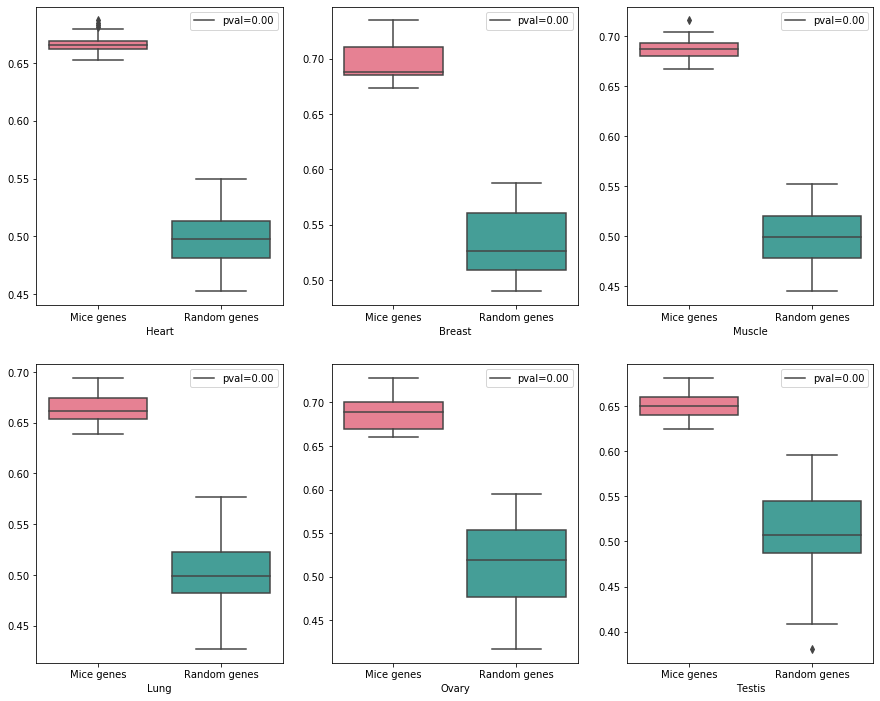

In [5]:
overlap_gene_len = []
Tissue = []
pvals = []
genes = []
mko_ranks = []
r_ranks = []
rep_tiss = []
fig = plt.figure(figsize=(15,45))

for i in range(1, 7):
    ax = fig.add_subplot(7, 3, i)
    tissue,code = tissue_input_pairs[i-1]
    Tissue.append(tissue)
    t = pd.read_excel('./data/mice_data/report.xlsx?doid=DOID:'+str(code), index_col=0)
    t  = t.replace({'\*':''}, regex=True)
    mice_genes = t['Human Homologs'].drop_duplicates().tolist()
    mice_genes = [x.strip(' ') for x in mice_genes]

    m,r,m_rel_genes = mice_test(mice_genes,gene_loov_df,tissue,np.random.choice(100, 1)[0])
    genes.append(m_rel_genes)
    overlap_gene_len.append(len(m_rel_genes))
    pval = scipy.stats.wilcoxon(m, r, zero_method='wilcox',alternative='greater')[1]
    print(pval)
    pvals.append(pval)
    ranks  = [m,r]
    rep_tiss+=list(itertools.repeat(tissue, len(m)))
    mko_ranks+=m
    r_ranks+=r
    names = ['Mice genes', 'Random genes']
    ax = sns.boxplot(data=ranks,palette="husl")
    ax.set(xticklabels=names)
    plt.xlabel(str(tissue))
#     plt.ylabel(str(ranks))

    ax.legend(labels = ['pval={0:0.2f}'.format(pval)]) 


In [14]:
mko.head()

,Tissue,genes,value
0,Heart,MKO_ranks,0.678052
1,Heart,MKO_ranks,0.679585
2,Heart,MKO_ranks,0.678989
3,Heart,MKO_ranks,0.671320
4,Heart,MKO_ranks,0.665991


Text(0.5, 0, '')

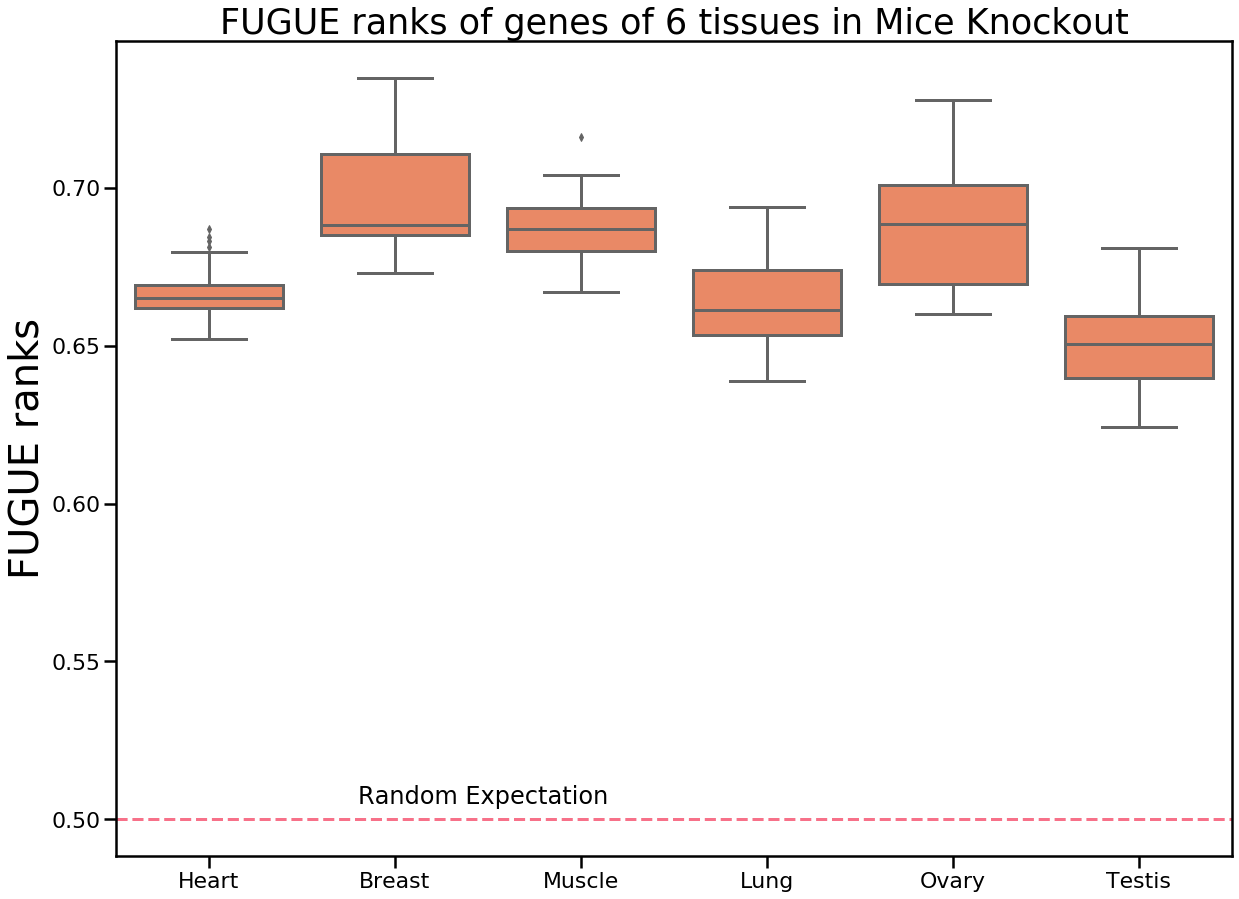

In [25]:


mko = pd.DataFrame({'Tissue':rep_tiss,'MKO_ranks':mko_ranks,'Rand_Ranks':r_ranks})
mko = pd.melt(mko, id_vars=['Tissue'], value_vars=['MKO_ranks','Rand_Ranks'])
mko.head()
mko = mko.rename(columns={'variable':'genes'})
mko = mko[mko['genes'] == 'MKO_ranks' ]


sns.set_context("poster")
fig = plt.figure(figsize=(20,15))

ax = sns.boxplot(x="Tissue", y="value",
                 data=mko, color="coral")
ax.axhline(0.5, ls='--')
ax.text(0.8,0.505, "Random Expectation")

# plt.xticks(rotation=40)
plt.title('FUGUE ranks of genes of 6 tissues in Mice Knockout',fontsize=35)

plt.ylabel('FUGUE ranks',fontsize = 40)
plt.xlabel('',fontsize = 40)

In [7]:
temp = pd.DataFrame({'Tissue':Tissue, 'numb_gene_overlap':overlap_gene_len,
             'P-value':pvals, 'Genes':genes})
temp.to_csv('./data/Mouse_KO_pvals.csv',index = False)
temp

,Tissue,numb_gene_overlap,P-value,Genes
0,Heart,179,3.778465e-10,"[LRP1, FKBP1B, TECRL, CALR, BMPR1A, PKD1, TCAP..."
1,Breast,33,1.385392e-02,"[ESPL1, RB1CC1, HMMR, BRCA1, CHEK2, RAD51, STA..."
2,Muscle,135,2.572638e-10,"[LRP1, KY, COL6A2, KLHL31, TCAP, TFAM, PYROXD1..."
3,Lung,66,8.401479e-08,"[RB1, MUC7, HMOX1, NDST1, SFTPB, FOXM1, NCF4, ..."
4,Ovary,33,2.531016e-03,"[ERRFI1, FMR1, POF1B, FGFR3, AKT2, TP53, NR5A1..."
5,Testis,54,5.600798e-09,"[MXI1, NANOS1, SYCP2, TEX14, CHEK2, MEIOB, CFA..."


In [36]:
tissue = 'Testis'
mice_genes = temp[temp['Tissue']==tissue]['Genes'].tolist()[0]

In [37]:
prob_df = gene_loov_df[['Tissue','Description','Probability']]

gt_param_df = pd.read_csv('./data_generated/gt_param_df_wlabel.csv')
gt_param_df = gt_param_df[['Tissue','Description','ZScore','MeanExp','Breadth','CV','NeighborMeanBreadth','NeighborMeanZscore','Label']]
gt_param_df = gt_param_df[gt_param_df['Description'].isin(mice_genes)]
gt_param_df = gt_param_df[gt_param_df['Tissue']==tissue]
gt_param_df = pd.merge(gt_param_df, prob_df,  how='inner', 
                       left_on=['Description','Tissue'], right_on = ['Description','Tissue'])
print(gt_param_df.shape)
gt_param_df.to_csv('./data_generated/miceko/miceko_'+ tissue +'.csv',index = False)

gt_param_df.head()

(54, 10)


,Tissue,Description,ZScore,MeanExp,Breadth,CV,NeighborMeanBreadth,NeighborMeanZscore,Label,Probability
0,Testis,BCL10,0.232099,12.962926,0.966759,0.183530,0.773089,1.038628,U,0.719660
1,Testis,BRDT,6.327982,115.424324,1.000000,0.416313,1.000000,1.908245,U,0.298051
2,Testis,RNASEL,-0.789524,2.485485,0.027701,0.441917,0.506002,-0.098375,U,0.768486
3,Testis,EHBP1,0.463155,36.518253,0.966759,0.311939,0.951247,2.197672,U,0.456478
4,Testis,AGFG1,1.370981,38.948059,1.000000,0.247573,0.811413,1.162174,U,0.813416


In [14]:

temp['Genes'][0]

['LRP1',
 'FKBP1B',
 'TECRL',
 'CALR',
 'BMPR1A',
 'PKD1',
 'TCAP',
 'SAP130',
 'KCNJ2',
 'MYH6',
 'SMAD6',
 'RPSA',
 'FBN1',
 'PPARG',
 'BMP10',
 'TMOD1',
 'DVL2',
 'DNM1L',
 'NOS3',
 'TGFB3',
 'CACNB2',
 'SNTA1',
 'NOTCH1',
 'NPPA',
 'RBPJ',
 'JUP',
 'FGF8',
 'ZFPM2',
 'TNNI3',
 'TRPM4',
 'LMNA',
 'MYOCD',
 'KCND3',
 'KCNA5',
 'RYR2',
 'NR1D2',
 'NUP155',
 'PLN',
 'DOCK1',
 'CALM2',
 'SCN5A',
 'HCN1',
 'LRRC10',
 'DCHS1',
 'GALNT1',
 'CENPF',
 'PTPN11',
 'DOT1L',
 'PROX1',
 'TNFSF4',
 'ACTC1',
 'ACSL1',
 'NCOA6',
 'PEPD',
 'KCNK3',
 'ERBB2',
 'ABCC9',
 'DNAH11',
 'PDLIM5',
 'GNAQ',
 'ECE1',
 'PSEN2',
 'NKX2-5',
 'MYOZ2',
 'DNAH5',
 'PHC1',
 'GATA6',
 'DICER1',
 'HCN4',
 'YME1L1',
 'XIRP1',
 'BAG3',
 'EYA4',
 'PSEN1',
 'CSRP3',
 'DTNA',
 'TRDN',
 'TPM1',
 'DMD',
 'KCNQ1',
 'MAP3K7',
 'CTSV',
 'GJA1',
 'TMEM43',
 'TTN',
 'DAG1',
 'CAV3',
 'GJA5',
 'MYL3',
 'DAAM1',
 'MDM4',
 'SCN1B',
 'DES',
 'GATAD1',
 'PTGER4',
 'MYPN',
 'PDLIM3',
 'CAP2',
 'MYH7',
 'NTF3',
 'SCN3B',
 'PKP2',
 'SGCD'